In [1]:
import pandas as pd
from bs4 import BeautifulSoup
from tqdm import tqdm
tqdm.pandas()
import numpy as np
import nltk
from nltk.tokenize import sent_tokenize
from nltk import tokenize

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import string
import re
import nltk

from tqdm import trange
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from collections import Counter

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import preprocessing, decomposition, model_selection, metrics, pipeline
from sklearn.metrics import accuracy_score, auc, roc_auc_score
import xgboost as xgb

In [3]:
df = pd.read_csv("./Data/ticaret-yorum.csv")
df

,category,text
0,alisveris,Altus Hırdavat Yapı Malzemeleri Drone Diye Kar...
1,alisveris,"Albay Bilgisayar Garanti Yalanı İle Yanılttı,G..."
2,alisveris,"Okyanus Petshop Ürün İade Sorunu!,Satıcıdan Gi..."
3,alisveris,Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Di...
4,alisveris,BB Kargo Dağıtım'dan Aldığım Ürün Bozuk Çıktı ...
...,...,...
431301,ulasim,Pegasus Kabin Boyu Bagajım İçin 20 Euro Aldıla...
431302,ulasim,"Pegasus Sefer Saat Değişikliği,""05.02.2020 tar..."
431303,ulasim,"THY Saygısız Müşteri Temsilcisi!,""THY'den bile..."
431304,ulasim,"KLM Havayolları Bilgisizlikleri,Kraliyet firma..."


<Axes: xlabel='category'>

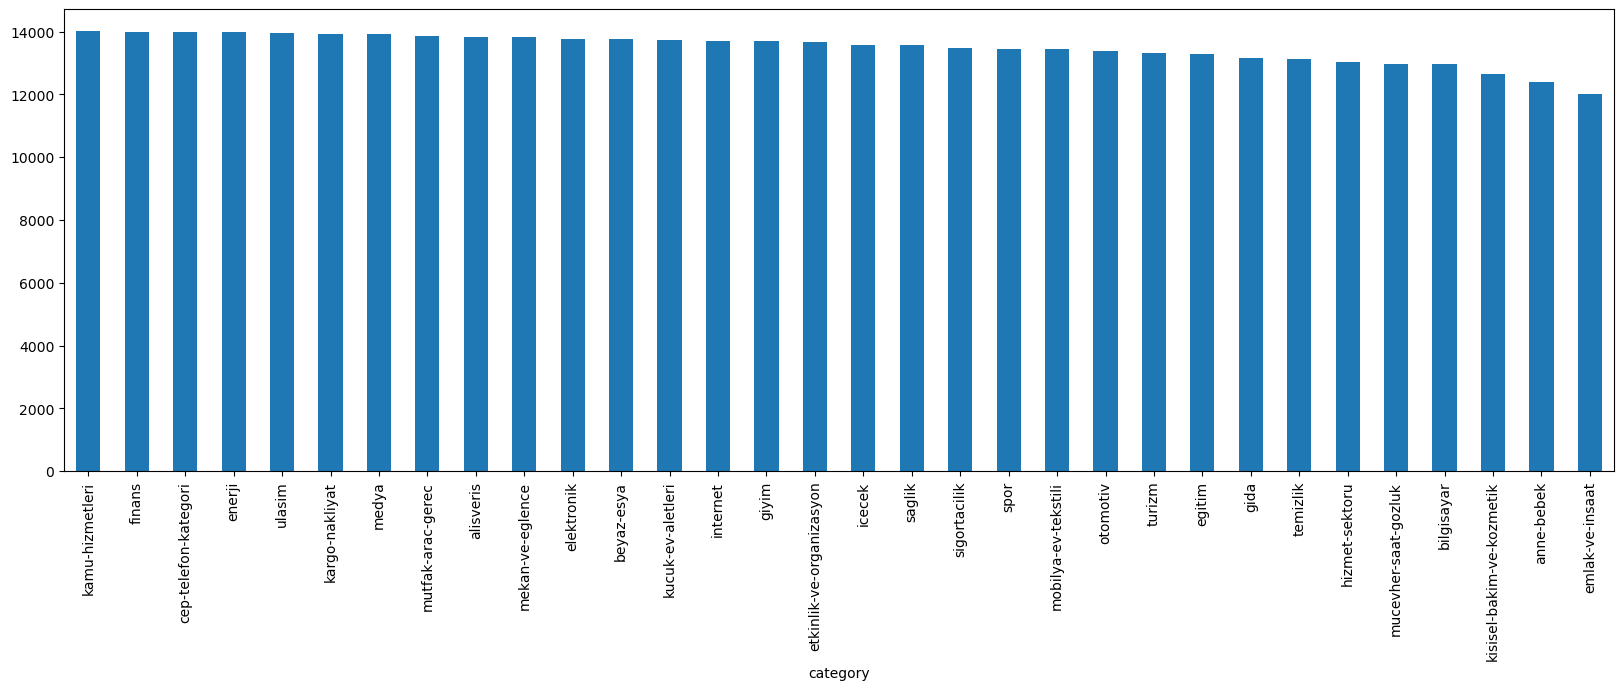

In [12]:
df.category.value_counts().plot.bar(x="Topics",y="Number of Reviews",figsize=(20,6) )

In [15]:
fulltext = ""
for i in range(len(df)):
    if i>1:
        fulltext += BeautifulSoup(df.iloc[i]['text']).get_text(" ") + ' '
fulltext[0:500] 

C:\Users\yusuf\AppData\Local\Temp\ipykernel_9644\1847413429.py:4: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  fulltext += BeautifulSoup(df.iloc[i]['text']).get_text(" ") + ' '


'Okyanus Petshop Ürün İade Sorunu!,Satıcıdan GittiGidiyor üzerinden 385 TL tutarında Frolicat Interactive Kedi Lazer oyuncağı satın aldım. Ürünü açıp bir kez çalıştırdığımda çok gürültü çıkardığını fark ettim ve ürünü iade etmeye karar verdim. Hatam iade sürecinin 14 gün içinde olması gerektiğini bilmemekti. Ürünü teslim aldıktan son...Devamını oku Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Dizlik Esnemiyor!,Anda ihtiyaç ve tüketim maddeleri pazarlama san. Lim. Şti. Den 139 TL kapıda teslim knee'

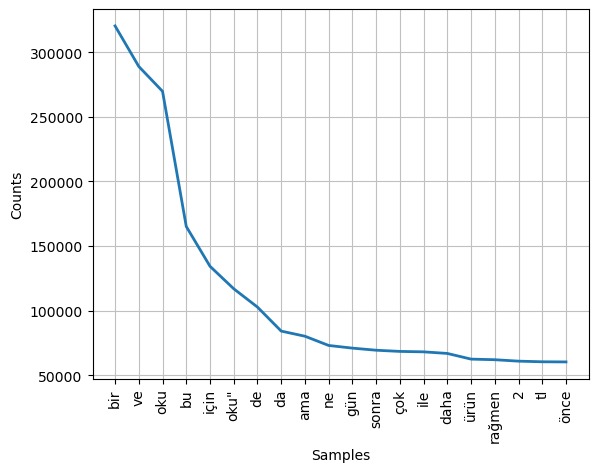

<Axes: xlabel='Samples', ylabel='Counts'>

In [16]:
lower_text = nltk.FreqDist(fulltext.lower().split(" ")) 
lower_text.plot(20,cumulative=False)

In [85]:
class TurkishNlp():
    def encokkelime(self,fulltext):
        four_letter_fd = nltk.FreqDist(w.lower() for w in text.split()) 
        print(four_letter_fd.most_common(10), end = '')
    
    def alfanumerik(self,fultext):
        numerikKarakter = sum(len(w) for w in text.split() if not w.isalnum())
        numerikKarakterYuzde = numerikKarakter / len(text.replace(" ","")) * 100
        print("Toplamda Karakter Sayılmayan Değişken Sayısı: {}".format(numerikKarakter))
        print("Toplamda Karakter olmayanların Total Metin içerisindeki Yüzdesi: {:%}".format(numerikKarakterYuzde)) 

In [86]:
turkishNlp = TurkishNlp()
turkishNlp.alfanumerik(fulltext)

Toplamda Karakter Sayılmayan Değişken Sayısı: 55
Toplamda Karakter olmayanların Total Metin içerisindeki Yüzdesi: 1815.181518%


In [48]:
stopwordsList = stopwords.words('english') + stopwords.words("turkish")
def clean_text(review):
    review = BeautifulSoup(review, 'html.parser').get_text(" ")
    review = re.sub(r'(?<![a-zA-ZçÇğĞıİöÖşŞüÜ])\w+|\w+(?![a-zA-ZçÇğĞıİöÖşŞüÜ])', ' ', review)
    review = review.lower()
    review = review.replace('&nbsp;', ' ').replace('“', ' ').replace('·', ' ').replace('i̇', 'i')
    review = review.replace('•', ' ').replace('\xa0', ' ')
    review = review.replace('”', ' ').replace('nan', '').replace('\r', '').replace('’', ' ')
    review = " ".join([word for word in review.split() if word not in stopwordsList])
    return review

def harfDonusum(fultext):
    fultext = re.sub(r"Â", "A", fultext)
    fultext = re.sub(r"â", "a", fultext)
    fultext = re.sub(r"Î", "I", fultext)
    fultext = re.sub(r"î", "ı", fultext)
    fultext = re.sub(r"Û", "U", fultext)
    fultext = re.sub(r"û", "u", fultext)
    return fultext

def tokenize(fultext):
    fultext = re.sub(r'http\S+', '', fultext)
    fultext = re.sub(r"#(\w+)", '', fultext)
    fultext = re.sub(r"@(\w+)", '', fultext)
    fultext = re.sub(r'[^\w\s]', '', fultext)
    fultext = fultext.strip().lower()
    fultext = fultext.replace('&nbsp;', ' ').replace('“', ' ').replace('·', ' ').replace('i̇','i')
    fultext = fultext.replace('•', ' ').replace('\xa0', ' ')
    fultext = fultext.replace('”', ' ').replace('nan', '').replace('\r', '').replace('’', ' ')
    fultext = " ".join([word for word in fultext.split() if word not in stopwordsList])
    return fultext

In [45]:
df["Temiz Text"] = df["text"].apply(clean_text)
df["Temiz Text"][0:10]

C:\Users\yusuf\AppData\Local\Temp\ipykernel_9644\293742349.py:3: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  review = BeautifulSoup(review, 'html.parser').get_text(" ")


0        ," ' . . , , , ... ... "
1                       , . . ...
2                    !, . . . ...
3      !, . . . . ... . . . . ...
4                        ' !, . .
5                           , ' .
6               , ' . / / . . ...
7             , . . . . . . . ...
8    ," **** **** , / / , . ... "
9              ," . . , , . ... "
Name: Temiz Text, dtype: object

In [49]:
df['Clean'] = df['text'].apply(tokenize)

In [87]:
df["Clean"].apply(harfDonusum)

0         altus hırdavat yapı malzemeleri drone kargodan...
1         albay bilgisayar garanti yalanı yanılttıgarant...
2         okyanus petshop ürün iade sorunusatıcıdan gitt...
3         anda ihtiyaç tüketim maddeleri knee tork dizli...
4         bb kargo dağıtımdan aldığım ürün bozuk çıktı m...
                                ...                        
431301    pegasus kabin boyu bagajım 20 euro aldılararka...
431302    pegasus sefer saat değişikliği05022020 tarihin...
431303    thy saygısız müşteri temsilcisithyden bileti a...
431304    klm havayolları bilgisizliklerikraliyet firmas...
431305    pegasus çağrı merkezipegasus internet sayfasın...
Name: Clean, Length: 431306, dtype: object

In [88]:
df

,category,text,Temiz Text,Clean
0,alisveris,Altus Hırdavat Yapı Malzemeleri Drone Diye Kar...,","" ' . . , , , ... ... """,altus hırdavat yapı malzemeleri drone kargodan...
1,alisveris,"Albay Bilgisayar Garanti Yalanı İle Yanılttı,G...",", . . ...",albay bilgisayar garanti yalanı yanılttıgarant...
2,alisveris,"Okyanus Petshop Ürün İade Sorunu!,Satıcıdan Gi...","!, . . . ...",okyanus petshop ürün iade sorunusatıcıdan gitt...
3,alisveris,Anda İhtiyaç Ve Tüketim Maddeleri Knee Tork Di...,"!, . . . . ... . . . . ...",anda ihtiyaç tüketim maddeleri knee tork dizli...
4,alisveris,BB Kargo Dağıtım'dan Aldığım Ürün Bozuk Çıktı ...,"' !, . .",bb kargo dağıtımdan aldığım ürün bozuk çıktı m...
...,...,...,...,...
431301,ulasim,Pegasus Kabin Boyu Bagajım İçin 20 Euro Aldıla...,", ' ' . ' . ' . ...",pegasus kabin boyu bagajım 20 euro aldılararka...
431302,ulasim,"Pegasus Sefer Saat Değişikliği,""05.02.2020 tar...",","" . . ' : ' , : ' : ' . , ... """,pegasus sefer saat değişikliği05022020 tarihin...
431303,ulasim,"THY Saygısız Müşteri Temsilcisi!,""THY'den bile...","!,"" ' , .",thy saygısız müşteri temsilcisithyden bileti a...
431304,ulasim,"KLM Havayolları Bilgisizlikleri,Kraliyet firma...",", ** . . . ...",klm havayolları bilgisizliklerikraliyet firmas...


In [70]:
from collections import Counter
from tqdm import trange
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    words = df['Clean'][i].split()
    corpus += words
encokKelime = Counter(corpus).most_common(10)
encokKelime

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████| 431306/431306 [00:05<00:00, 81097.55it/s]


[('oku', 386863),
 ('bir', 323358),
 ('gün', 71479),
 ('yok', 70843),
 ('sonra', 70245),
 ('aldım', 67563),
 ('2', 66729),
 ('rağmen', 64804),
 ('ürün', 64055),
 ('tl', 63753)]

In [92]:
def length(text):
    df["Length"] = df["Clean"].str.len()
    return df
def word_count(text):
    review_list = text.split()
    return len(review_list)
def kelimesayı(text):
    df["Kelime_Sayısı"] = df["Clean"].progress_apply(word_count)
    return df
def ortalama_kelime_uzunlugu(text):
    df["ortalama_kelime_uzunlugu"] = df["Clean"].map(lambda rev:np.mean([len(word) for word in rev.split()]))
    df["ortalama_kelime_uzunlugu"]= df["ortalama_kelime_uzunlugu"].round(4)
    return df
def ortalama_cümle_uzunlugu(text):
    df["ortalama_cümle_uzunlugu"] = df["Clean"].map(lambda rev:np.mean([len(sent) for sent in tokenize.sent_tokenize(rev)]))
    return df

In [ ]:
"""df["Lenght"] = df["Clean"].apply(length)
df["Kelime_Sayısı"] = df["Clean"].apply(kelimesayı)
df["ortalama_kelime_uzunlugu"] = df["Clean"].apply(ortalama_kelime_uzunlugu)
df["ortalama_cümle_uzunlugu"] = df["Clean"].apply(ortalama_cümle_uzunlugu)
df"""

In [95]:
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
df["categorical_label"] = le.fit_transform(df["category"])
df["categorical_label"] = df["categorical_label"].astype(int)

In [96]:
print(f'Categorik Label Sayısı:',len(df["categorical_label"].unique()))

Categorik Label Sayısı: 32


In [97]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, auc, roc_auc_score

In [122]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

### N-gram Vektörleştirme ###
##N-gram vektörleştirme, metni sayısal değerlerin vektörlerine dönüştürmek için kullanılan yaygın bir metin sınıflandırma tekniğidir.
def ngram_vectorize(train_texts, train_labels, val_texts, NGRAM_RANGE=(1, 2), TOP_K=20000,
                    TOKEN_MODE='word', MIN_DOCUMENT_FREQUENCY=2, vForm='tfidf'):
    """
    1 metin = unigram + bigram kelime haznesinin uzunluğunda bir tf-idf vektörüdür.

    # Argümanlar
        train_texts: liste, eğitim metin dizeleri.
        train_labels: np.ndarray, eğitim etiketleri.
        val_texts: liste, doğrulama metin dizeleri.
        NGRAM_RANGE: Farklı n-gramların çıkarılacağı n-değerlerinin alt ve üst sınırları.
        TOP_K: SelectKBest tarafından seçilecek maksimum özellik sayısı.
        TOKEN_MODE: Metnin kelime veya karakter n-gramlarına bölünüp bölünmeyeceğini belirler.
        MIN_DOCUMENT_FREQUENCY: Bir belgede/korpus frekansının altında olan bir belirteç atılacaktır.
        vForm: Vektörleştirme biçimi, 'tfidf' veya 'count' olabilir.

    # Dönüşler
        x_train, x_val: vektörleştirilmiş eğitim ve doğrulama metinleri
    """
    # 'tf-idf' vektörleyiciye geçirilecek anahtar kelime argümanlarını oluşturun.
    kwargs = {
        'ngram_range': NGRAM_RANGE,  # 1-gramlar + 2-gramlar kullanılacak.
        'dtype': 'int32',
        'strip_accents': 'unicode',
        'decode_error': 'replace',
        'analyzer': TOKEN_MODE,  # Metni kelime parçacıklarına böler.
        'min_df': MIN_DOCUMENT_FREQUENCY,
    }

    if vForm == 'tfidf':
        vectorizer = TfidfVectorizer(**kwargs)
    elif vForm == 'count':
        vectorizer = CountVectorizer(**kwargs) 
    else:
        print('Geçersiz vektörleştirme biçimi')
        return

    # Eğitim metinlerinden kelime haznesini öğrenin ve eğitim metinlerini vektörleştirin.
    x_train = vectorizer.fit_transform(train_texts)

    # Doğrulama metinlerini vektörleştirin.
    x_val = vectorizer.transform(val_texts)

    # Vektörleştirilmiş özelliklerin en üst 'k'sini seçin.
    selector = SelectKBest(f_classif, k=min(TOP_K, x_train.shape[1]))
    selector.fit(x_train, train_labels)
    x_train = selector.transform(x_train).astype('float32')
    x_val = selector.transform(x_val).astype('float32')
    return x_train, x_val, vectorizer

In [147]:
x_train, x_test, y_train, y_test,indices_train,indices_test = train_test_split(df['Clean'].values.astype('U'), 
                                                    df['categorical_label'],
                                                    df.index, 
                                                    test_size=0.1, 
                                                    random_state=42,
                                                    stratify=df['categorical_label'])
print(x_train.shape, x_test.shape, y_train.shape, y_test.shape)

(388175,) (43131,) (388175,) (43131,)


In [100]:
xtrain_tfv,xvalid_tfv,vectorizer = ngram_vectorize(x_train, y_train, x_test, vForm = 'tfidf',  NGRAM_RANGE = (1, 2),
                                        TOP_K = 20000, TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2)

c:\Users\yusuf\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


In [101]:
from sklearn.decomposition import TruncatedSVD
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import GridSearchCV 
from sklearn.svm import SVC
from sklearn.metrics import roc_auc_score

In [102]:
lr = LogisticRegression(solver='sag',verbose=1)
lr.fit(xtrain_tfv, y_train)
y_pred = lr.predict(xvalid_tfv)
lr_skor = accuracy_score(y_test, y_pred)
sonuc = ('Logistic Regression Accuracy: ',lr_skor)
sonuc

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


convergence after 16 epochs took 27 seconds


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   26.9s finished


('Logistic Regression Accuracy: ', 0.9182954255639795)

In [103]:
xtrain_tfv,xvalid_tfv,vectorizer = ngram_vectorize(x_train, y_train, x_test, vForm = 'tfidf',  NGRAM_RANGE = (1, 1),
                                        TOP_K = 20000, TOKEN_MODE = 'word',MIN_DOCUMENT_FREQUENCY = 2)
clf = xgb.XGBClassifier(max_depth=7, n_estimators=200, colsample_bytree=0.8, 
                        subsample=0.8, nthread=10, learning_rate=0.1,jobs=-1)
clf.fit(xtrain_tfv.tocsc(), y_train)
y_pred_word = clf.predict(xvalid_tfv.tocsc())
LR_results=accuracy_score(y_test, y_pred_word)
sonuc = ('XGBoost Accuracy: ',LR_results)

c:\Users\yusuf\anaconda3\Lib\site-packages\sklearn\feature_extraction\text.py:2065: UserWarning: Only (<class 'numpy.float64'>, <class 'numpy.float32'>, <class 'numpy.float16'>) 'dtype' should be used. int32 'dtype' will be converted to np.float64.
  warnings.warn(


[11:28:29] WARNING: C:\buildkite-agent\builds\buildkite-windows-cpu-autoscaling-group-i-0fdc6d574b9c0d168-1\xgboost\xgboost-ci-windows\src\learner.cc:767: 
Parameters: { "jobs" } are not used.



In [105]:
sonuc

('XGBoost Accuracy: ', 0.9270130532563585)

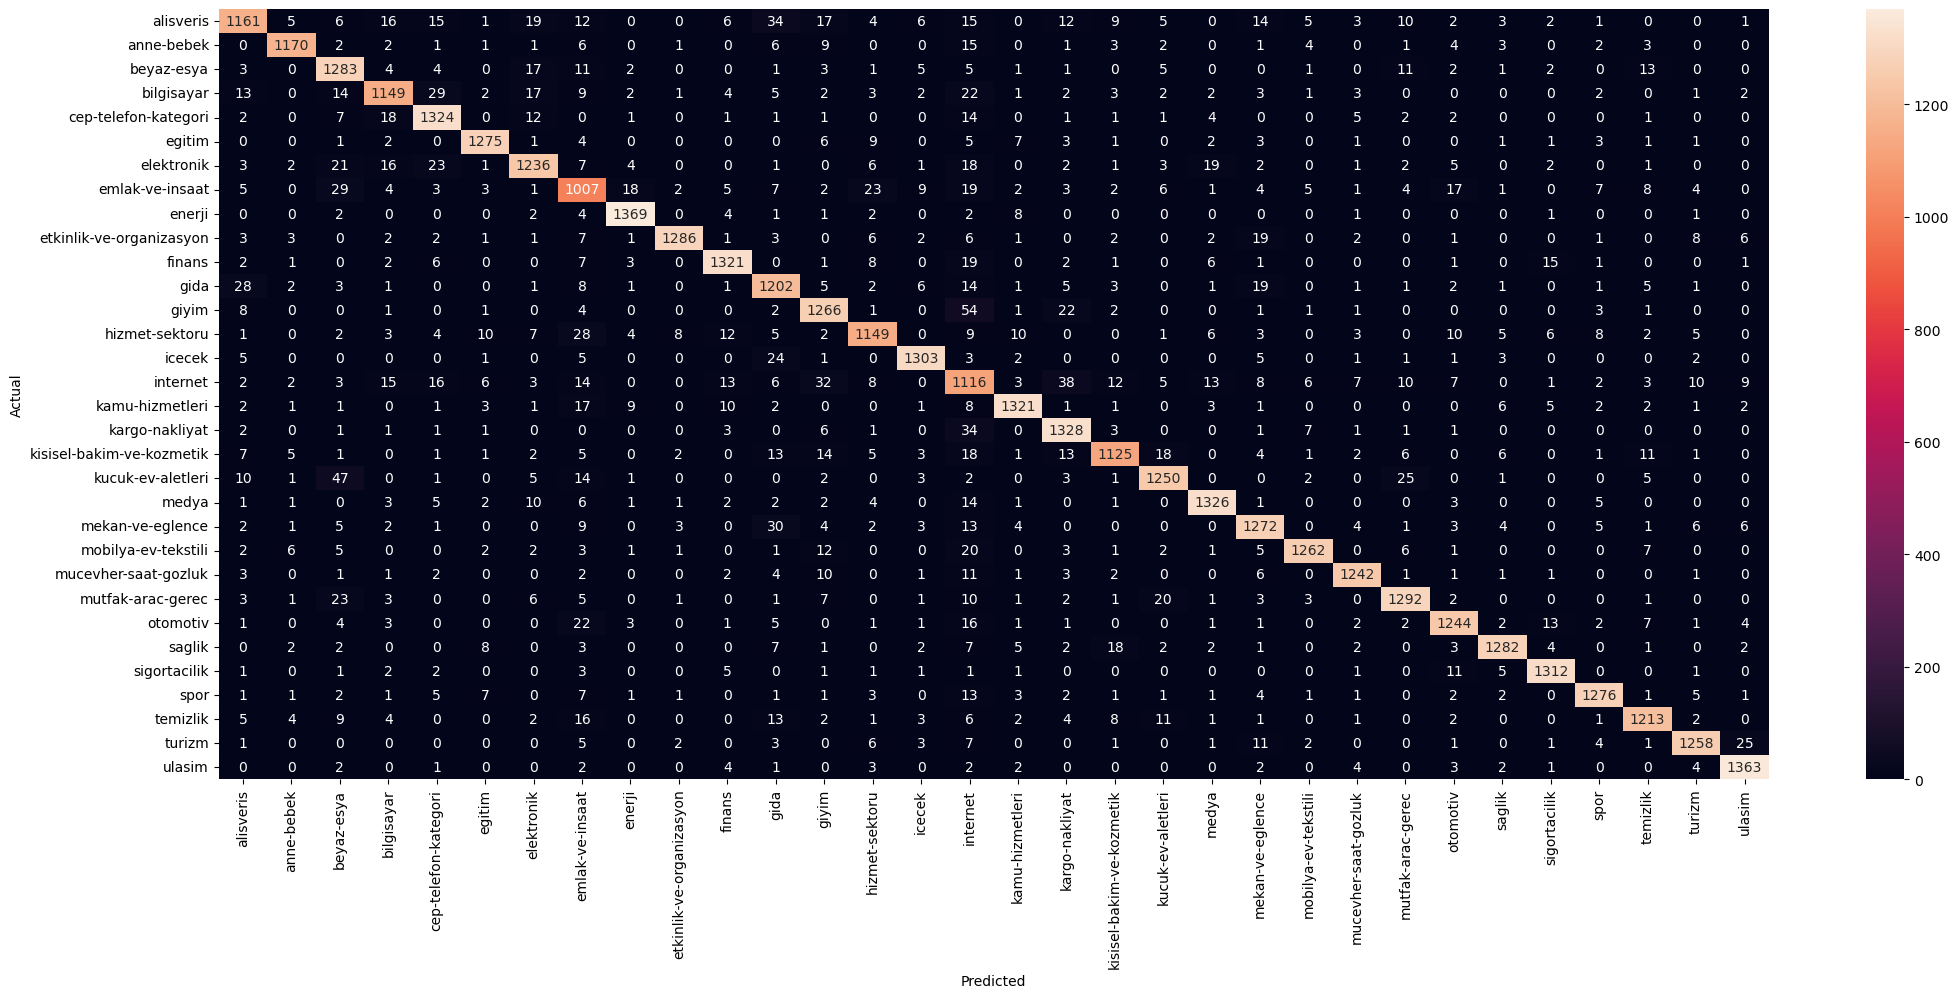

In [138]:
from sklearn.metrics import confusion_matrix
conf_mat = confusion_matrix(y_test, y_pred_word)
fig, ax = plt.subplots(figsize=(25,10))

sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=df['category'].unique(), yticklabels=df['category'].unique())
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [139]:
labelsWithName = df.filter(items=['category', 'categorical_label']).drop_duplicates()
labelsWithName

,category,categorical_label
0,alisveris,0
13835,anne-bebek,1
26217,beyaz-esya,2
39980,bilgisayar,3
52944,cep-telefon-kategori,4
66925,egitim,5
80194,elektronik,6
93966,emlak-ve-insaat,7
105990,enerji,8
119969,etkinlik-ve-organizasyon,9


In [155]:
from IPython.display import display
for index, predicted in labelsWithName.iterrows():
  for index, actual in labelsWithName.iterrows(): 
    if predicted['categorical_label'] != actual['categorical_label'] and conf_mat[actual['categorical_label'], predicted['categorical_label']] >= 30:
      print("'{}' predicted as '{}' : {} examples.".format(actual['category'], predicted['category'], conf_mat[actual['categorical_label'], predicted['categorical_label']]))
      display(df.loc[indices_test[(y_test == actual['categorical_label']) & (y_pred_word == predicted['categorical_label'])]][['category','Clean']].head(5))
      print('')

'kucuk-ev-aletleri' predicted as 'beyaz-esya' : 47 examples.


,category,Clean
260520,kucuk-ev-aletleri,bosch müşteri memnuniyetini sağlayamıyorboschu...
256418,kucuk-ev-aletleri,arçelik olmayan stoktaki ürünleri satıyorlarar...
263243,kucuk-ev-aletleri,arçelik ütünün bitmeyen sıkıntısıarçelikten al...
261385,kucuk-ev-aletleri,arçelik servisinin umursamazlığıbodrum turgutr...
268352,kucuk-ev-aletleri,arçelik sorumsuzluğuürünler bozuluyor yardımcı...



'alisveris' predicted as 'gida' : 34 examples.


,category,Clean
7994,alisveris,özlem yem yumurta içerik sorunuözlem yemin üre...
10209,alisveris,çelikkayalar market personel saygısızlığı soru...
9207,alisveris,a101 çokça kahvaltılık sos bozuk çıktıbir haft...
13558,alisveris,furpa marketler aldığımız tulumba bayat çıktıd...
4465,alisveris,faber castell grip 2011 kapak sorunuyeni aldığ...



'mekan-ve-eglence' predicted as 'gida' : 30 examples.


,category,Clean
286166,mekan-ve-eglence,ekmek satan bayan asla maske takmıyorbu salgın...
288217,mekan-ve-eglence,bozuk gıdaseyidoğlu bahçelievler esenler şubel...
292096,mekan-ve-eglence,cookshop saçlı yemekleriizmir hilltown cooksho...
285862,mekan-ve-eglence,hemşin unlu mamüllerinde poğaçanın içinden saç...
285272,mekan-ve-eglence,kerebiçci oğuz ürünümüz tamamen ezilmişsayın y...



'internet' predicted as 'giyim' : 32 examples.


,category,Clean
206532,internet,hediyesepeticomda ürünümün hazırlığına ilişkin...
207976,internet,kitapbudurcomdan kitaplarım gelmedikb280542957...
204804,internet,benimolsunbutik instagramkullanılmış kirli aya...
206082,internet,gittigidiyorda gönderilmeyen kargo18052020 tar...
210437,internet,trendyol iade yapmıyor sorunu çözmüyor14052020...



'giyim' predicted as 'internet' : 54 examples.


,category,Clean
169203,giyim,nine west siparişin hazırlanamaması sorunu5 ma...
174368,giyim,armour iade işlemi olmasına rağmen para iadesi...
173083,giyim,deichmann iptal olan ürün ücretimgeçen hafta k...
168191,giyim,benetton elimde değişim kaynaklı fişim var kul...
167005,giyim,derimod ürünüm eksik geldiderimodun trendyol ü...



'kargo-nakliyat' predicted as 'internet' : 34 examples.


,category,Clean
236330,kargo-nakliyat,hepsijet kargom bugün vermek ekstra 14 tl öded...
233264,kargo-nakliyat,hepsijette iletişim yok ürün yok3 haziranda el...
237450,kargo-nakliyat,fedex hatalı gümrük bedeli fahiş geri taşıma ü...
235027,kargo-nakliyat,trendyol expresste ürünüm 1 ayı aşkın süredir ...
238754,kargo-nakliyat,mng kargo iade kodu yanlış dedikargo şirketi ç...



'internet' predicted as 'kargo-nakliyat' : 38 examples.


,category,Clean
211138,internet,amazon ürün iade almıyor40706829131483502 aldı...
211250,internet,hepsiburada ürünü iade edemiyorumhepsiburadaco...
203686,internet,trendyoldan siparişim gelmedibana bugün kargo ...
204719,internet,kitabın başkenti 25 günde gelen kirli kitaplar...
204258,internet,takidukkanicom param iade edilmedits180476 sip...


In [160]:
from IPython.display import display
correlated_terms = {}
for index, predicted in labelsWithName.iterrows():
    correlated_terms[predicted['categorical_label']] = set() 
    for index, actual in labelsWithName.iterrows():
        if predicted['categorical_label'] != actual['categorical_label'] and conf_mat[actual['categorical_label'], predicted['categorical_label']] >= 5:
            misclassified_examples = df.loc[indices_test[(y_test == actual['categorical_label']) & (y_pred_word == predicted['categorical_label'])]]
            for example in misclassified_examples['Clean']:
                terms = example.split()
                correlated_terms[predicted['categorical_label']].update(terms)
for label, terms in correlated_terms.items():
    print("Sınıf '{}' ile en çok ilişkili terimler:".format(label))
    print(list(terms)[:10])
    print('')

Sınıf '0' ile en çok ilişkili terimler:
['gereğinin', 'rağmen', 'level', 'aldığın', 'hazırlanıyor', 'pek', 'üretmiyor', 'pastırma', 'yetkililere', 'gerekir']

Sınıf '1' ile en çok ilişkili terimler:
['üretim', 'money', 'anlatıyoruz', 'hazırlanıyor', 'edip', 'ürünü', 'irite', 'telefonlarına', 'tarafı', 'sandalyesi']

Sınıf '2' ile en çok ilişkili terimler:
['bozulduğunu', 'gereğinin', 'rağmen', 'lahana', '30', 'yapmak', 'süpürgemi', 'piyasaya', 'deterjanıyla', 'tabakta']

Sınıf '3' ile en çok ilişkili terimler:
['gereğinin', 'rağmen', 'çalışmıyor', 'şifrede', '700', 'edip', 'casper', 'kapattı', 'sorunlar', 'yanlış']

Sınıf '4' ile en çok ilişkili terimler:
['rağmen', 'çalışmıyor', 'yapmak', 'çakılı', 'artış', 'scooterımı', 'edip', 'yetkililere', 'casper', 'operatöre']

Sınıf '5' ile en çok ilişkili terimler:
['yatırıyorlar', 'iğneli', 'rağmen', 'çürük', 'zorluk', 'yapmak', 'insanlar', 'bankası', 'sordum', 'sigarayı']

Sınıf '6' ile en çok ilişkili terimler:
['rağmen', 'çalışmıyor', '30'

In [162]:
sonuc_lr = ('Logistic Regression Accuracy: ',lr_skor)
sonuc_xgb = ('XGBoost Accuracy: ',LR_results)
sonuc = (sonuc_lr,sonuc_xgb)
sonuc